# Plot Heating Profiles

We are really lucking to have the ICON restart files. Fortunately, they contain much more additional data that are very helpful, e.g. short- and longwave heating profile.

The profiles will be combined with cloud cover information stored in standard output.

## Import Libraries

In [49]:
%matplotlib inline

import sys, os
import datetime
import numpy as np
import scipy.ndimage

import xarray as xr
import importlib

import pylab as plt
plt.rcParams['figure.figsize'] = (12,8)
import seaborn as sns
sns.set_context( 'talk' )


# import nawdex_analysis.io.tools

In [2]:
tools_dir = '%s/proj/2017-11_icon-de-lem-analysis/tools' % os.environ['HOME']

import sys
sys.path.append(tools_dir)

In [3]:
import domain_budgets, input_regrid5km
importlib.reload( input_regrid5km )

<module 'input_regrid5km' from '/pf/b/b380352/proj/2017-11_icon-de-lem-analysis/tools/input_regrid5km.py'>

## Open Files

### Heating Profiles

In [4]:

######################################################################
######################################################################

import os
import numpy as np
import xarray as xr
import nawdex_analysis.io.tools

######################################################################
######################################################################

def input_data4exp(dom = 'DOM01', mode = 'absorbing', regrid_method = 'nn', time_string = '0000Z'):
            
    '''
    Returns regridded simulation restart data (pre-selected variables).

    
    Parameters
    ----------
    dom : ('DOM01', 'DOM02'), optional
        select grid spacing via domain argument

    mode : ('absorbing', 'scattering'), optional
        if sim with or w/o absorption is taken

    
    Returns
    -------
    d : xr.Dataset
        regridded restart data read from disk


    Notes
    -----
    Nearest neighbor regridding used starting from restart data.
    '''

    # select sim experiment
    if mode == 'absorbing':
        subpath = '20130502_CCN_rad'
    elif mode == 'scattering':
        subpath = '20130502_semi_direct_effect'
    
    if dom == 'DOM01':
        region_str = 'R0625m'
    elif dom == 'DOM02':
        region_str = 'nest_R0312m'
    
   
    # read data
    if regrid_method == 'nn':
        fdir = '%s/icon-lem/restart_columns/%s' % (os.environ['LOCAL_DATA_PATH'], subpath )
    else:
        fdir = '%s/icon-lem/%s/RESTART/' % (os.environ['LOCAL_DATA_PATH'], subpath )
    

    fname = '%s/hdcp2_cosmodom_%s_restart_atm_20130502T*%s_subset_regrid5km.nc' % (fdir, region_str, time_string)
    
    d = xr.open_mfdataset( fname, chunks = {'time': 1}, combine='by_coords' )
    # d = d.expand_dims( 'time')
    # patch time vector
    time_vector = nawdex_analysis.io.tools.convert_timevec( d.time.data )
    d['time'] = time_vector
    
    d = d.expand_dims(['mode','dom'])
    d['mode'] = [mode, ]
    d['dom']  = [dom, ]
    
    return d

######################################################################
######################################################################


def input_data( regrid_method = 'nn', time_string = '0000Z' ):
       
    '''
    Returns combination of all regridded restart data.

    
    Returns
    -------
    d : xr.Dataset
        regridded simulation read from disk
    '''

    dlist = []
    
    for dom in ['DOM01', 'DOM02']:
        for mode in['absorbing', 'scattering']:
            
            d_input = input_data4exp(dom = dom, 
                                     mode = mode, 
                                     regrid_method = regrid_method, 
                                     time_string = time_string)
            
            d_resampled = d_input #temporal_resampling( d_input )
            
            dlist += [d_resampled.copy(), ]
            
    return xr.merge( dlist, join = 'outer' )


In [5]:
kws = dict( regrid_method = 'interpolation', time_string = '110000Z' )
t = datetime.datetime(2013, 5, 2, 11, 0)

dset_heating = input_data( **kws )



In [6]:
dset_heating

<xarray.Dataset>
Dimensions:                (depth: 8, depth_2: 9, depth_3: 1, depth_4: 1, dom: 2, height: 1, height_2: 1, lat: 155, lev: 150, lev_2: 151, lev_3: 2, lev_4: 3, lon: 139, mode: 2, time: 1)
Coordinates:
  * dom                    (dom) object 'DOM01' 'DOM02'
  * mode                   (mode) object 'absorbing' 'scattering'
  * time                   (time) datetime64[ns] 2013-05-02T11:00:00
  * lon                    (lon) float64 4.5 4.572 4.643 ... 14.22 14.3 14.37
  * lat                    (lat) float64 47.5 47.54 47.59 ... 54.32 54.37 54.41
  * lev_2                  (lev_2) float64 1.0 2.0 3.0 4.0 ... 149.0 150.0 151.0
  * lev                    (lev) float64 1.0 2.0 3.0 4.0 ... 148.0 149.0 150.0
  * height                 (height) float64 10.0
  * depth                  (depth) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0
  * height_2               (height_2) float64 2.0
  * depth_2                (depth_2) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0
  * lev_3                  (lev_3) float64 1.0 2.0
  * lev_4                  (lev_4) float64 1.0 2.0 3.0
  * depth_3                (depth_3) float64 1.0
  * depth_4                (depth_4) float64 1.0
Data variables:
    w.TL1                  (mode, dom, time, lev_2, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 151, 155, 139), meta=np.ndarray>
    rho.TL1                (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    theta_v.TL1            (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    exner.TL1              (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    qv.TL1                 (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    qc.TL1                 (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    qi.TL1                 (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    qr.TL1                 (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    qs.TL1                 (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    qg.TL1                 (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    qh.TL1                 (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    qni.TL1                (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    qnr.TL1                (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    qns.TL1                (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    qng.TL1                (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    qnh.TL1                (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    qnc.TL1                (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    ninact.TL1             (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    tke.TL1                (mode, dom, time, lev_2, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 151, 155, 139), meta=np.ndarray>
    w.TL3                  (mode, dom, time, lev_2, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 151, 155, 139), meta=np.ndarray>
    rho.TL3                (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    theta_v.TL3       

In [7]:
dset_heating = dset_heating[['ddt_temp_radsw', 'ddt_temp_radlw', 'w.TL1']]
dset_heating = input_regrid5km.map_level_and_halflevel_in_icondata( dset_heating, 
                                                                    full_lev_name = 'lev',
                                                                    half_lev_name = 'lev_2')

###  Cloud Cover

In [8]:
dset_cc = input_regrid5km.input_fields('cloud', t )

/pf/b/b380352/data/icon-lem/20130502_CCN_rad/DATA/2d_cloud_*DOM01*20130502T1100*_regrid5km.nc


/pf/b/b380352/proj/2017-11_icon-de-lem-analysis/tools/input_regrid5km.py:70: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  d = xr.open_mfdataset( flist, chunks = {'time':1} ).squeeze()
/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


/pf/b/b380352/data/icon-lem/20130502_semi_direct_effect/DATA/2d_cloud_*DOM01*20130502T1100*_regrid5km.nc
/pf/b/b380352/data/icon-lem/20130502_CCN_rad/DATA/2d_cloud_*DOM02*20130502T1100*_regrid5km.nc
/pf/b/b380352/data/icon-lem/20130502_semi_direct_effect/DATA/2d_cloud_*DOM02*20130502T1100*_regrid5km.nc


### Combination of the two Datasets 

In [100]:
dset = xr.merge( [dset_cc[['clt', 'clcl', 'clcm']], dset_heating.squeeze()])

## Set Domain-Average Clearsky & Allsky

### Smooth Cloud Cover Field First

In [101]:
cc = dset['clt'].load().data

In [102]:
cc.shape

(2, 2, 155, 139)

In [103]:
cc_sm = scipy.ndimage.gaussian_filter( cc, (0,0,2,2))

In [104]:
dset['clt_smooth'] = xr.zeros_like( dset['clt'] )
dset['clt_smooth'].data = cc_sm 

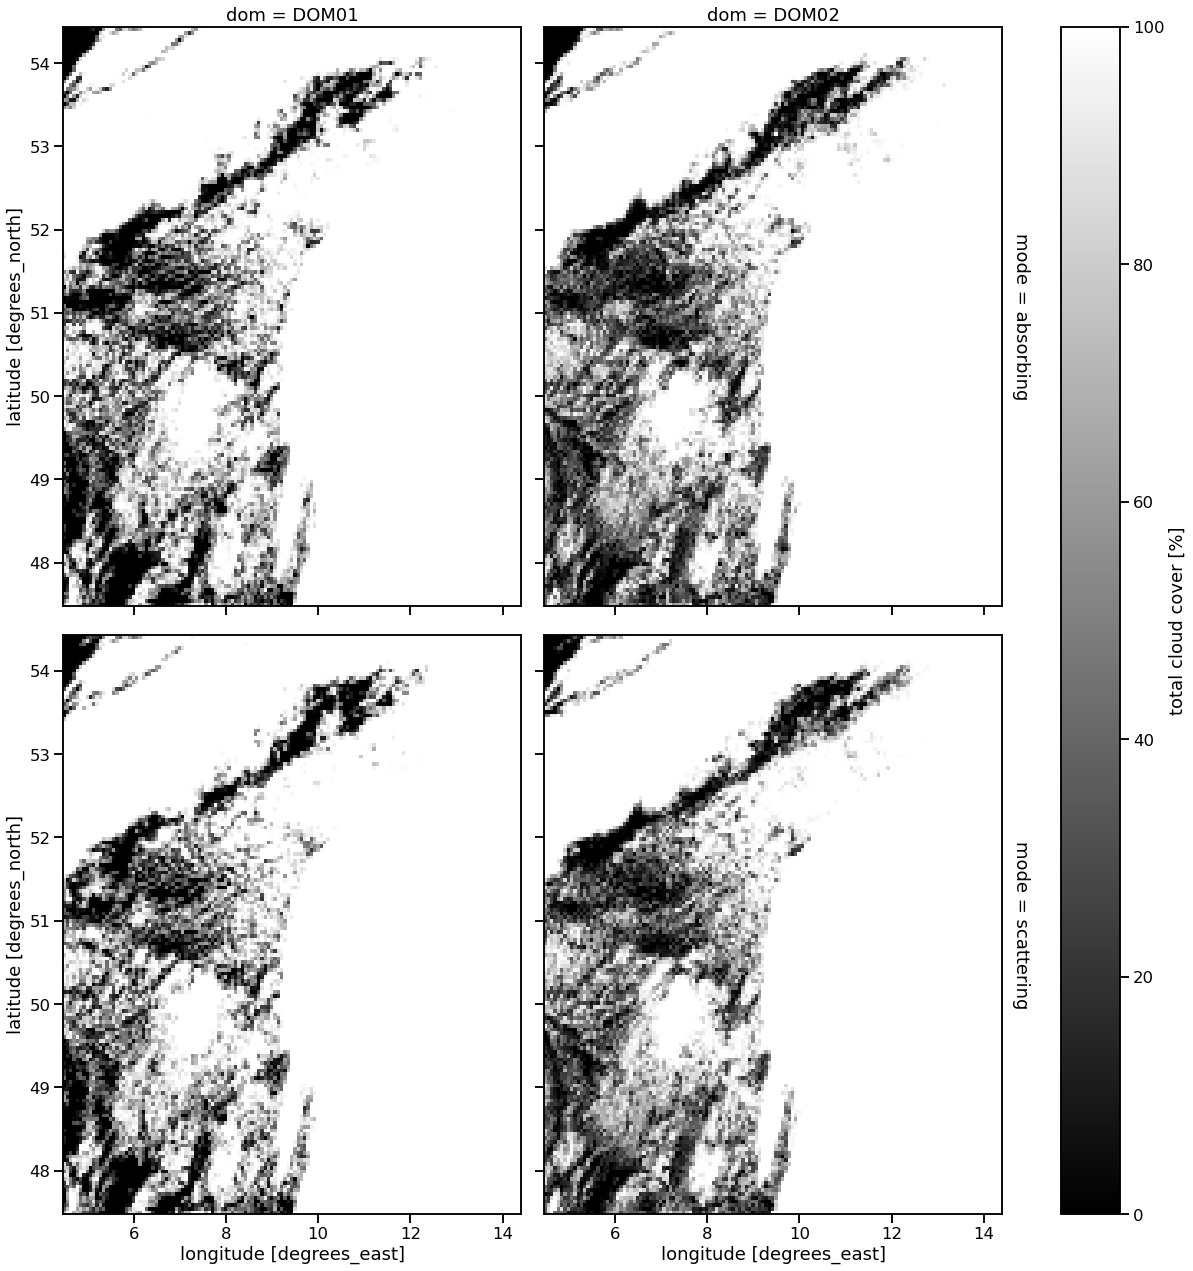

In [105]:
dset['clt'].plot( row = 'mode', col = 'dom', figsize = (18,18), cmap = plt.cm.gray)

### Clearsky

In [106]:
qmask = dset['clt'] == 0
qmask = qmask.prod( ['mode', 'dom'] )
dclear_domain_mean = dset.where( qmask ).mean( ['lon', 'lat'])

In [107]:
dclear_domain_mean.compute()

dclear_domain_mean = input_regrid5km.get_difference( dclear_domain_mean )

### Allsky

In [108]:
qmask = dset['clt'] >= 0.
qmask = qmask.prod( ['mode', 'dom'] )
dallsky_domain_mean = dset.where( qmask ).mean( ['lon', 'lat'])

In [109]:
dallsky_domain_mean.compute()

dallsky_domain_mean = input_regrid5km.get_difference( dallsky_domain_mean )

### Overcast

In [117]:
qmask = dset['clt_smooth'] > 95.
qmask = qmask.prod( ['mode', 'dom'] )
dovercast_domain_mean = dset.where( qmask ).mean( ['lon', 'lat'])

In [118]:
dovercast_domain_mean.compute()

dovercast_domain_mean = input_regrid5km.get_difference( dovercast_domain_mean )

### Broken

In [119]:
qmask = ( dset['clt_smooth'] > 25. ) & ( dset['clt_smooth'] < 75.)
qmask = qmask.prod( ['mode', 'dom'] )
dbroken_domain_mean = dset.where( qmask ).mean( ['lon', 'lat'])

In [120]:
dbroken_domain_mean.compute()

dbroken_domain_mean = input_regrid5km.get_difference( dbroken_domain_mean )

### Get Average Pressure Nice Heating Rates Plot

In [121]:
from  input_regrid5km import get_ave_pressure_profile

In [122]:
pm = get_ave_pressure_profile( t )


/pf/b/b380352/data/icon-lem/20130502_semi_direct_effect/DATA/3d_coarse_*DOM01*20130502T1100*_regrid5km.nc


/pf/b/b380352/proj/2017-11_icon-de-lem-analysis/tools/input_regrid5km.py:70: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  d = xr.open_mfdataset( flist, chunks = {'time':1} ).squeeze()
/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [123]:
pm = pm.rename( {'height_2': 'full_level'})

### Difference in Clearsky

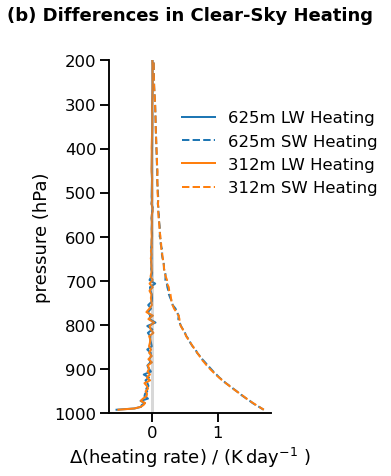

In [124]:
fig, ax = plt.subplots( ncols = 1, figsize = (5,7) )
plt.subplots_adjust( top = 0.85, bottom = 0.15, right = 0.7, left = 0.25)


cols = ['C0', 'C1']
labpre = ['625m', '312m']
mode = 'difference'

for i, dom in enumerate( dclear_domain_mean.dom ): 
        
        # LONGWAVE
        d = dclear_domain_mean.sel(dom = dom, mode = mode).squeeze()
        x = 3600 * 24 * d['ddt_temp_radlw']
        y = pm
        
        plt.plot(x, y, color = cols[i], lw = 2, label = '%s LW Heating' % labpre[i] )

        # SHORTWAVE
        x = 3600 * 24 * d['ddt_temp_radsw']
        y = pm
        
        plt.plot(x, y, color = cols[i], ls = '--', lw = 2, label = '%s SW Heating' % labpre[i] )
        
plt.axvline( 0, lw = 3, color = 'gray', alpha = 0.3)
plt.ylim(1000, 200)
sns.despine()
plt.legend( frameon = False, loc = 'upper right', bbox_to_anchor = (1.75, 0.9))
plt.xlabel( '$\Delta$(heating rate) / ($\mathrm{K\,day^{-1}}$ )')
plt.ylabel( 'pressure (hPa)')
plt.title( '(b) Differences in Clear-Sky Heating' , fontweight = 'bold', pad = 40 )
plt.savefig('../pics/heating-prof-difference.png', dpi = 300)

### Absolute Profiles in Clearsky

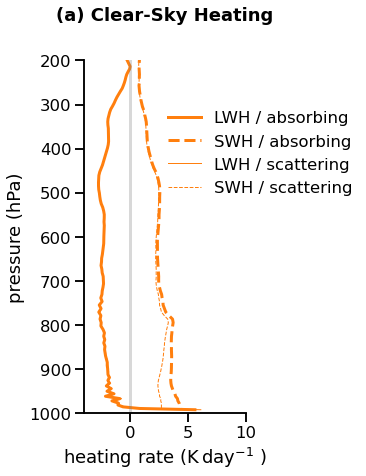

In [125]:
fig, ax = plt.subplots( ncols = 1, figsize = (5,7) )
plt.subplots_adjust( top = 0.85, bottom = 0.15, right = 0.7, left = 0.25)

cols = ['C0', 'C1']
labpre = ['625m', '312m']
lws = [3, 1]
dom = 'DOM02'
for k, mode in enumerate( ['absorbing', 'scattering'] ):
                    # LONGWAVE
                    d = dclear_domain_mean.sel(dom = dom, mode = mode)
                    x = 3600 * 24 * d['ddt_temp_radlw']
                    y = pm

                    plt.plot(x, y, color = cols[i], lw = lws[k], label = 'LWH / %s' % str( mode ))

                    # SHORTWAVE
                    d = dclear_domain_mean.sel(dom = dom, mode = mode)
                    x = 3600 * 24 * d['ddt_temp_radsw']
                    y = pm

                    plt.plot(x, y, color = cols[i], lw = lws[k], ls = '--', label = 'SWH / %s' % mode )
        
plt.axvline( 0, lw = 3, color = 'gray', alpha = 0.3)
plt.ylim(1000, 200)
plt.xlim(-4, 10)
sns.despine()
plt.legend( frameon = False, loc = 'upper right', bbox_to_anchor = (1.75, 0.9))
plt.xlabel( 'heating rate ($\mathrm{K\,day^{-1}}$ )')
plt.ylabel( 'pressure (hPa)')
plt.title( '(a) Clear-Sky Heating' ,  fontweight = 'bold', pad = 40)
plt.savefig('../pics/heating-prof.png', dpi = 300)

### Impacts of Clouds on Shortwave Heating

In [126]:
mode = 'difference'

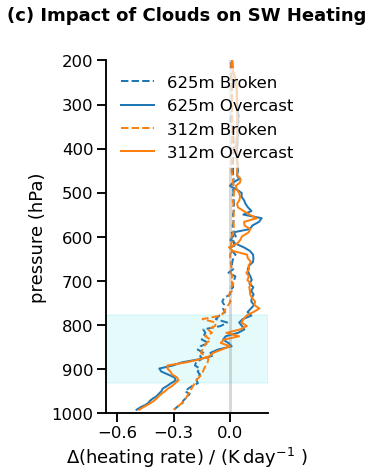

In [127]:
fig, ax = plt.subplots( ncols = 1, figsize = (5,7) )
plt.subplots_adjust( top = 0.85, bottom = 0.15, right = 0.7, left = 0.25)


cols = ['C0', 'C1']
labpre = ['625m', '312m']
dom = 'DOM01'
lss = ['--', '-']

dref = dclear_domain_mean

dlist = [( dbroken_domain_mean - dref ), ( dovercast_domain_mean - dref ) ]
lablist = ['Broken', 'Overcast']

for i, dom in enumerate( dref.dom ): 

    for k, drela in enumerate( dlist ):        # LONGWAVE

    # LONGWAVE
        d = drela.sel(dom = dom, mode = mode)
        # SHORTWAVE
        x = 3600 * 24 * d['ddt_temp_radsw']
        y = pm
        
        plt.plot(x, y, color = cols[i], ls = lss[k], lw = 2, label = '%s %s' % ( labpre[i], lablist[k]) )
        
plt.axvline( 0, lw = 3, color = 'gray', alpha = 0.3)


# include the liquid layer here, copied from notebook 05-Average-TD-profiles and hard-coded...
h1, h2 = 778.1495972842262, 931.0229864211309
plt.axhspan(h1, h2, color='darkturquoise', alpha=0.1)

sns.despine()
plt.ylim(1000, 200)
plt.legend( frameon = True, loc = 'upper left', 
            facecolor = 'white', edgecolor = 'white', 
            framealpha = 0.7)#, bbox_to_anchor = (1.4, 0.05))
plt.xlim(-0.66,)
plt.xticks([-0.6, -0.3,  0] )
plt.xlabel( '$\Delta$(heating rate) / ($\mathrm{K\,day^{-1}}$ )')
plt.ylabel( 'pressure (hPa)')
plt.title( '(c) Impact of Clouds on SW Heating' , fontweight = 'bold', pad = 40)
plt.savefig('../pics/heating-prof-clouds-impact.png', dpi = 300)